## 進階機器學習 HW5-2-2
Train a VAE using the entire MNIST training dataset, setting the latent
space dimension to 2.

* 學號: B103040047
* 姓名: 周安

In [59]:
!pip install tqdm
!pip install torchinfo

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary
import pandas as pd

import random

# for reproduce rsult
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    generator = torch.Generator().manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    return generator
generator = same_seeds(122)

# Check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

Train on cuda.


In [61]:
### Load the MNIST & FashionMNIST dataseet.
from torchvision import datasets, transforms
# preprocess
BATCH_SIZE = 128
compose = [
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Update mean/std for 1 channel, normalize value into [-1, 1]
]
transform = transforms.Compose(compose)

# MNIST Training Data（normal data）
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# MNIST Test Data
# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
# mnist_test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

print("MNIST Train:", len(mnist_train))
# print("MNIST Test:", len(mnist_test))

MNIST Train: 60000


### i.
#### Train a VAE with the latent space dimension 2.
* latent space is (batch_size, 2, 1, 1)

In [117]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Linear(128, 2),# laten space is  2
        )
        self.enc_out_2 = nn.Sequential(
            nn.Linear(128, 2),# laten space is  2
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1 * 28 * 28),
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() # e^(sigma * 0.5)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # e * sigma + mu

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        mu, logvar = self.encode(x) # get the mu and logvar, but need to get sigma=var^0.5 from logvar
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE的訓練使用的是一種特殊的損失函數，即「重建損失」和「KL 散度（Kullback-Leibler divergence）」的組合，又稱為ELBO。
# 重建損失衡量生成樣本的質量，而KL 散度則衡量潛在變數的分佈與標準正態分佈之間的差異。
def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x) * x.shape[0]
    # KL Divergence = -0.5 * sum(1 + logvar - mu^2 - e^logvar)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

def loss_mse(recon_x, x, criterion):
    """
    recon_x: generating images
    x: origin images
    """
    mse = criterion(recon_x, x) * x.shape[0]
    return mse

def loss_kld(mu, logvar):
    """
    mu: latent mean
    logvar: latent log variance
    """
    # KL Divergence = -0.5 * sum(1 + logvar - mu^2 - e^logvar)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return KLD

In [118]:
# Hyper Parameters
LR = [0.001, 0.001, 0.001] # case 1 2 3
IMAGE_SIZE = 28

vae = VAE().to(device)

# set loss function
criterion = nn.MSELoss()
# set optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=LR[0], betas=(0.9, 0.999))
# Print the model summary
summary(vae, (1, 1, IMAGE_SIZE, IMAGE_SIZE)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Linear: 2-1                       [1, 512]                  401,920
│    └─ReLU: 2-2                         [1, 512]                  --
│    └─Linear: 2-3                       [1, 128]                  65,664
│    └─ReLU: 2-4                         [1, 128]                  --
├─Sequential: 1-2                        [1, 2]                    --
│    └─Linear: 2-5                       [1, 2]                    258
├─Sequential: 1-3                        [1, 2]                    --
│    └─Linear: 2-6                       [1, 2]                    258
├─Sequential: 1-4                        [1, 784]                  --
│    └─Linear: 2-7                       [1, 128]                  384
│    └─ReLU: 2-8                         [1, 128]                  --
│  

In [111]:
from tqdm import tqdm
# train and val func for one epoch
def train_epoch_1(train_dataloader, model, criterion, optimizer):
    model.train()
    tot_loss = list()
    for x, _ in tqdm(train_dataloader):
        x = x.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        output, mu, logvar = model(x)
        # see loss
        loss = loss_mse(output, x, criterion) / x.shape[0] # get average on this batch
        loss.backward()

        # update the parameters
        optimizer.step()

        tot_loss.append(loss.item())
    return np.mean(tot_loss)

def train_epoch_2(train_dataloader, model, criterion, optimizer):
    model.train()
    tot_loss = list()
    for x, _ in tqdm(train_dataloader):
        x = x.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        output, mu, logvar = model(x)
        # see loss
        loss = loss_kld(mu, logvar) / x.shape[0] # get average on this batch
        loss.backward()

        # update the parameters
        optimizer.step()

        tot_loss.append(loss.item())
    return np.mean(tot_loss)

def train_epoch_3(train_dataloader, model, criterion, optimizer):
    model.train()
    tot_loss = list()
    for x, _ in tqdm(train_dataloader):
        x = x.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        output, mu, logvar = model(x)
        # see loss
        loss = loss_vae(output, x, mu, logvar, criterion) / x.shape[0] # get average on this batch
        loss.backward()

        # update the parameters
        optimizer.step()

        tot_loss.append(loss.item())
    return np.mean(tot_loss)

def test_3(test_dataloader, model, criterion):
    tot_loss = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(test_dataloader):
            _, loss = recreate_img_vae(x, model, criterion)
            tot_loss.append(loss.item())
    return np.mean(tot_loss)

def recreate_img_mse(img_batch, model, criterion):
    model.eval()
    with torch.no_grad():
        img_batch = img_batch.to(device)
        # predicting
        output, mu, logvar = model(img_batch)
        # see loss
        loss = loss_mse(output, img_batch, criterion) / img_batch.shape[0] # shape: (batch, C, H, W)
    return output, loss  # return each image's loss

def recreate_img_kld(img_batch, model, criterion):
    model.eval()
    with torch.no_grad():
        img_batch = img_batch.to(device)
        # predicting
        output, mu, logvar = model(img_batch)
        # see loss
        loss = loss_kld(mu, logvar) / img_batch.shape[0] # shape: (batch, C, H, W)
    return output, loss  # return each image's loss

def recreate_img_vae(img_batch, model, criterion):
    model.eval()
    with torch.no_grad():
        img_batch = img_batch.to(device)
        # predicting
        output, mu, logvar = model(img_batch)
        # see loss
        loss = loss_vae(output, img_batch, mu, logvar, criterion) / img_batch.shape[0] # shape: (batch, C, H, W)
    return output, loss  # return each image's loss

def plt_loss_accuracy_fig_2(Total_training_loss):
    # visualization the loss and accuracy
    plt.figure()
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    plt.title('Training & Validation loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Function to draw the distribution of mean and var from latent code.

In [95]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_latent_stats(model, dataloader, device):
    model.eval()
    all_mu = []
    all_var = []
    all_labels = []

    with torch.no_grad():
        for x, labels in dataloader:
            # Move data to the selected device (CPU/GPU)
            x = x.to(device)

            # Pass through encoder to get mean and log-variance
            x = x.view(x.shape[0], -1)
            mu, logvar = model.encode(x)
            # Compute variance by exp(logvar)
            var = torch.exp(logvar)

            # Move tensors to CPU and convert to numpy arrays
            all_mu.append(mu.cpu().numpy())
            all_var.append(var.cpu().numpy())
            all_labels.append(labels.numpy())

    # Concatenate data from all batches
    all_mu = np.concatenate(all_mu, axis=0)
    all_var = np.concatenate(all_var, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # 📈 Plot latent mean distribution
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=all_mu[:, 0],   # Mean of latent dim 1
        y=all_mu[:, 1],   # Mean of latent dim 2
        hue=all_labels,   # Color by digit label
        palette='tab10',
        s=15
    )
    plt.title("Latent Space Mean Distribution (μ)")
    plt.xlabel("μ1")
    plt.ylabel("μ2")
    plt.legend(title='Digit')
    plt.grid(True)
    plt.show()

    # 📈 Plot latent variance distribution
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=all_var[:, 0],   # Variance of latent dim 1
        y=all_var[:, 1],   # Variance of latent dim 2
        hue=all_labels,    # Color by digit label
        palette='tab10',
        s=15
    )
    plt.title("Latent Space Variance Distribution (σ²)")
    plt.xlabel("σ1²")
    plt.ylabel("σ2²")
    plt.legend(title='Digit')
    plt.grid(True)
    plt.show()


#### (a) Using only reconstruction loss

In [91]:
# Start training and testing
best_loss = 100
NUM_EPOCHS = 30
# For ploting the trend image
total_train_loss = []
for i in range(NUM_EPOCHS):
    train_loss = train_epoch_1(train_loader, vae, criterion, optimizer)
    # record the training data
    total_train_loss.append(train_loss)
    print("Epoch[{:>2d}/{:>2d}] : train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_loss))
    # update model pth when larger val_acc happens
    if(train_loss < best_loss):
        best_loss = train_loss
        save_parameters = True
        if save_parameters:
            path = 'MNIST_TRAIN_VAE_linear_onlyMSE.pth'
            torch.save(vae.state_dict(), path)
            print("\t\33[33m==== Save model at epoch {:d} | best_loss = {:.4f} ====\33[0m".format(i+1, best_loss))

# save the final epoch's model
path = 'MNIST_TRAIN_VAE_linear_onlyMSE_final_epoch.pth'
torch.save(vae.state_dict(), path)
print("\t\33[33m==== Save FINAL model parameters in {:s} ====\33[0m".format(path))

100%|██████████| 469/469 [00:12<00:00, 37.37it/s]


Epoch[ 1/30] : train_loss = 0.2149
	==== Save model at epoch 1 | best_loss = 0.2149 ====


100%|██████████| 469/469 [00:12<00:00, 37.81it/s]


Epoch[ 2/30] : train_loss = 0.1746
	==== Save model at epoch 2 | best_loss = 0.1746 ====


100%|██████████| 469/469 [00:12<00:00, 37.47it/s]


Epoch[ 3/30] : train_loss = 0.1659
	==== Save model at epoch 3 | best_loss = 0.1659 ====


100%|██████████| 469/469 [00:12<00:00, 37.81it/s]


Epoch[ 4/30] : train_loss = 0.1611
	==== Save model at epoch 4 | best_loss = 0.1611 ====


100%|██████████| 469/469 [00:12<00:00, 37.96it/s]


Epoch[ 5/30] : train_loss = 0.1580
	==== Save model at epoch 5 | best_loss = 0.1580 ====


100%|██████████| 469/469 [00:12<00:00, 37.63it/s]


Epoch[ 6/30] : train_loss = 0.1558
	==== Save model at epoch 6 | best_loss = 0.1558 ====


100%|██████████| 469/469 [00:12<00:00, 37.71it/s]


Epoch[ 7/30] : train_loss = 0.1540
	==== Save model at epoch 7 | best_loss = 0.1540 ====


100%|██████████| 469/469 [00:12<00:00, 37.01it/s]


Epoch[ 8/30] : train_loss = 0.1520
	==== Save model at epoch 8 | best_loss = 0.1520 ====


100%|██████████| 469/469 [00:12<00:00, 37.00it/s]


Epoch[ 9/30] : train_loss = 0.1506
	==== Save model at epoch 9 | best_loss = 0.1506 ====


100%|██████████| 469/469 [00:12<00:00, 36.68it/s]


Epoch[10/30] : train_loss = 0.1493
	==== Save model at epoch 10 | best_loss = 0.1493 ====


100%|██████████| 469/469 [00:12<00:00, 36.70it/s]


Epoch[11/30] : train_loss = 0.1484
	==== Save model at epoch 11 | best_loss = 0.1484 ====


100%|██████████| 469/469 [00:12<00:00, 37.31it/s]


Epoch[12/30] : train_loss = 0.1477
	==== Save model at epoch 12 | best_loss = 0.1477 ====


100%|██████████| 469/469 [00:12<00:00, 36.85it/s]


Epoch[13/30] : train_loss = 0.1462
	==== Save model at epoch 13 | best_loss = 0.1462 ====


100%|██████████| 469/469 [00:12<00:00, 36.63it/s]


Epoch[14/30] : train_loss = 0.1457
	==== Save model at epoch 14 | best_loss = 0.1457 ====


100%|██████████| 469/469 [00:12<00:00, 36.87it/s]


Epoch[15/30] : train_loss = 0.1451
	==== Save model at epoch 15 | best_loss = 0.1451 ====


100%|██████████| 469/469 [00:12<00:00, 36.98it/s]


Epoch[16/30] : train_loss = 0.1446
	==== Save model at epoch 16 | best_loss = 0.1446 ====


100%|██████████| 469/469 [00:12<00:00, 37.64it/s]


Epoch[17/30] : train_loss = 0.1440
	==== Save model at epoch 17 | best_loss = 0.1440 ====


100%|██████████| 469/469 [00:12<00:00, 36.81it/s]


Epoch[18/30] : train_loss = 0.1436
	==== Save model at epoch 18 | best_loss = 0.1436 ====


100%|██████████| 469/469 [00:12<00:00, 36.49it/s]


Epoch[19/30] : train_loss = 0.1431
	==== Save model at epoch 19 | best_loss = 0.1431 ====


100%|██████████| 469/469 [00:12<00:00, 37.58it/s]


Epoch[20/30] : train_loss = 0.1428
	==== Save model at epoch 20 | best_loss = 0.1428 ====


100%|██████████| 469/469 [00:12<00:00, 37.70it/s]


Epoch[21/30] : train_loss = 0.1429


100%|██████████| 469/469 [00:12<00:00, 36.74it/s]


Epoch[22/30] : train_loss = 0.1421
	==== Save model at epoch 22 | best_loss = 0.1421 ====


100%|██████████| 469/469 [00:12<00:00, 37.34it/s]


Epoch[23/30] : train_loss = 0.1417
	==== Save model at epoch 23 | best_loss = 0.1417 ====


100%|██████████| 469/469 [00:12<00:00, 37.15it/s]


Epoch[24/30] : train_loss = 0.1415
	==== Save model at epoch 24 | best_loss = 0.1415 ====


100%|██████████| 469/469 [00:12<00:00, 37.23it/s]


Epoch[25/30] : train_loss = 0.1414
	==== Save model at epoch 25 | best_loss = 0.1414 ====


100%|██████████| 469/469 [00:12<00:00, 37.72it/s]


Epoch[26/30] : train_loss = 0.1409
	==== Save model at epoch 26 | best_loss = 0.1409 ====


100%|██████████| 469/469 [00:12<00:00, 37.07it/s]


Epoch[27/30] : train_loss = 0.1410


100%|██████████| 469/469 [00:12<00:00, 36.17it/s]


Epoch[28/30] : train_loss = 0.1405
	==== Save model at epoch 28 | best_loss = 0.1405 ====


100%|██████████| 469/469 [00:13<00:00, 35.84it/s]


Epoch[29/30] : train_loss = 0.1407


100%|██████████| 469/469 [00:12<00:00, 36.35it/s]

Epoch[30/30] : train_loss = 0.1399
	==== Save model at epoch 30 | best_loss = 0.1399 ====
	==== Save FINAL model parameters in MNIST_TRAIN_VAE_linear_onlyMSE_final_epoch.pth ====


Best Loss: 0.13989877727812033


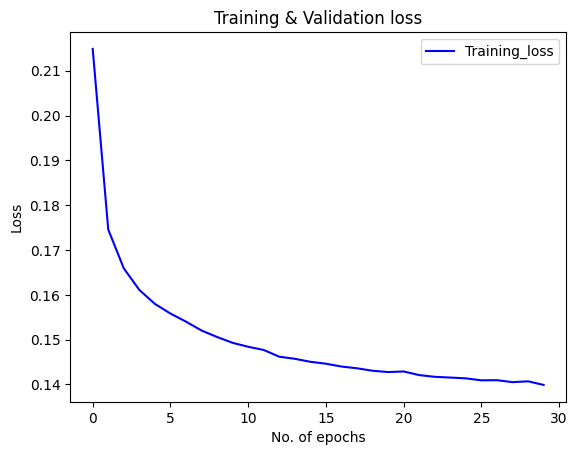

In [92]:
print("Best Loss:",best_loss)
plt_loss_accuracy_fig_2(total_train_loss)

In [128]:
vae = VAE().to(device)
pth_path = 'MNIST_TRAIN_VAE_linear_onlyMSE.pth'
state_dict = torch.load(pth_path)
vae.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
vae.eval()
eval_loss = nn.MSELoss()

Load pth from MNIST_TRAIN_VAE_linear_onlyMSE.pth


See the result of recreating.

Loss: [0.16980835795402527, 0.09533485025167465, 0.23758678138256073, 0.031275857239961624, 0.13419531285762787]


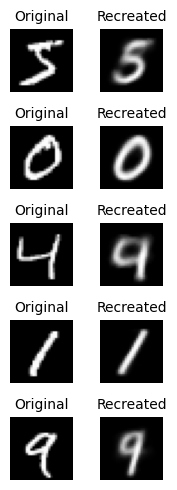

In [105]:
total_output = list()
total_test_loss = list()
for i in range(5):
    img, _ = mnist_train[i]
    img_batch = img.unsqueeze(0)
    output, loss = recreate_img_mse(img_batch, vae, eval_loss)
    total_output.append((img.cpu().detach().numpy().squeeze(0), output.cpu().detach().numpy().squeeze(0)))
    total_test_loss.append(loss.cpu().item())
print("Loss:", total_test_loss)

plt.figure(figsize=(2, 5))
for i, img_idx in enumerate(range(5)):
    img, output_img = total_output[img_idx]

    # image subplot
    ax_img = plt.subplot(5, 2, 2 * i + 1)
    ax_img.imshow(img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Original", fontsize=10)
    ax_img = plt.subplot(5, 2, 2 * i + 2)
    ax_img.imshow(output_img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Recreated", fontsize=10)
plt.tight_layout()
plt.show()


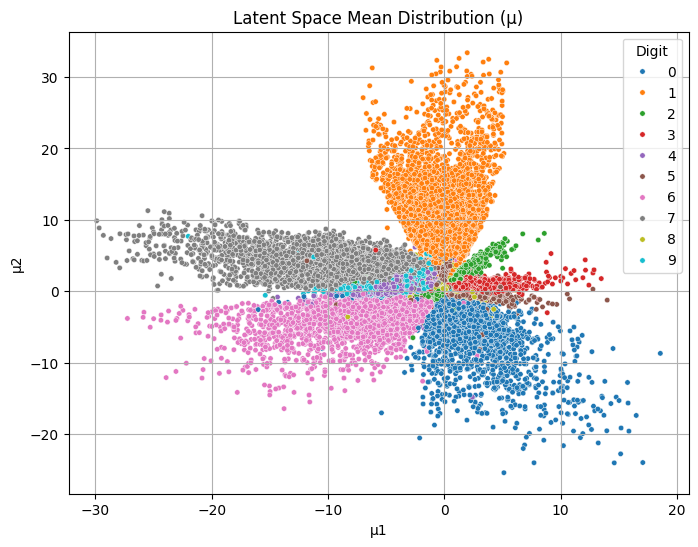

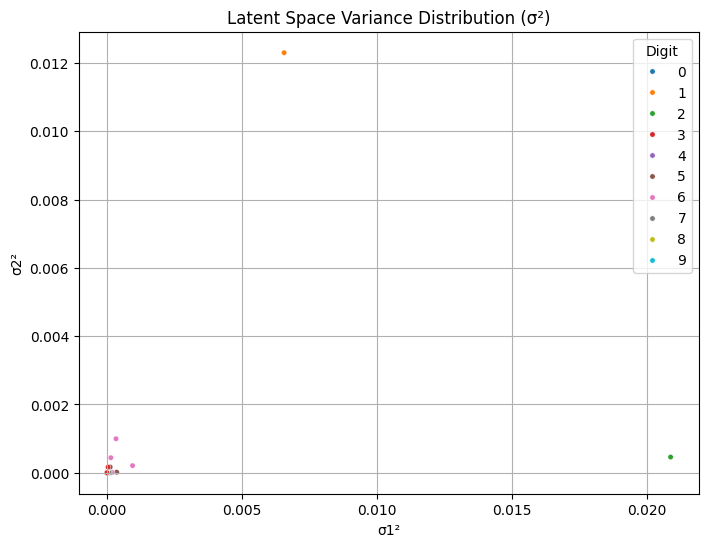

In [98]:
visualize_latent_stats(vae, train_loader, device)

Use decoder to generate some images.

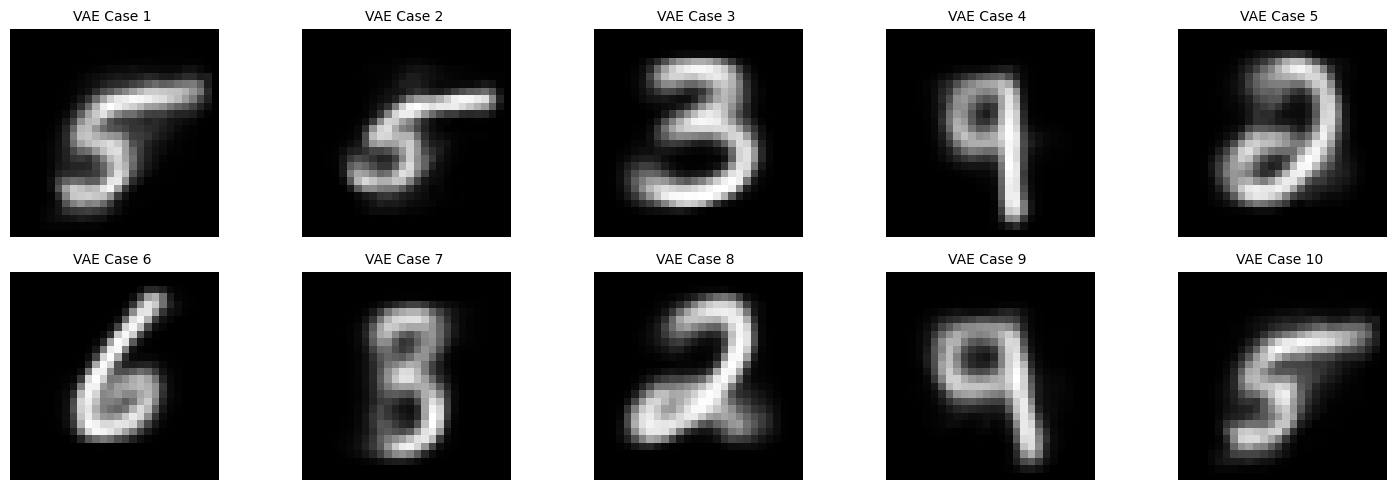

In [130]:
N = 10 # test cases number
# get the decoders
decoder_VAE = vae.decode
# input shape
input_vae = torch.zeros((1, 2))
plt.figure(figsize=(15, 5))
for i in range(N):
    with torch.no_grad():
        x = torch.randn_like(input_vae)
        x = x.to(device)
        out = decoder_VAE(x)
        ax = plt.subplot(2, 5, i+1)
        ax.imshow(out.cpu().squeeze(0,1), cmap='gray')
        ax.axis("off")
        ax.set_title(f"VAE Case {i+1} ", fontsize=10)
plt.tight_layout()
plt.show()

#### (b) Using only KL divergence loss

In [119]:
# Start training and testing
best_loss = 100
NUM_EPOCHS = 30
# For ploting the trend image
total_train_loss = []
for i in range(NUM_EPOCHS):
    train_loss = train_epoch_2(train_loader, vae, criterion, optimizer)
    # record the training data
    total_train_loss.append(train_loss)
    print("Epoch[{:>2d}/{:>2d}] : train_loss = {:.8f}".format(i+1, NUM_EPOCHS, train_loss))
    # update model pth when larger val_acc happens
    if(train_loss < best_loss):
        best_loss = train_loss
        save_parameters = True
        if save_parameters:
            path = 'MNIST_TRAIN_VAE_linear_onlyKLD.pth'
            torch.save(vae.state_dict(), path)
            print("\t\33[33m==== Save model at epoch {:d} | best_loss = {:.8f} ====\33[0m".format(i+1, best_loss))

# save the final epoch's model
path = 'MNIST_TRAIN_VAE_linear_onlyKLD_final_epoch.pth'
torch.save(vae.state_dict(), path)
print("\t\33[33m==== Save FINAL model parameters in {:s} ====\33[0m".format(path))

100%|██████████| 469/469 [00:12<00:00, 38.10it/s]


Epoch[ 1/30] : train_loss = 0.00092970
	==== Save model at epoch 1 | best_loss = 0.00092970 ====


100%|██████████| 469/469 [00:12<00:00, 38.27it/s]


Epoch[ 2/30] : train_loss = 0.00001796
	==== Save model at epoch 2 | best_loss = 0.00001796 ====


100%|██████████| 469/469 [00:12<00:00, 38.08it/s]


Epoch[ 3/30] : train_loss = 0.00000830
	==== Save model at epoch 3 | best_loss = 0.00000830 ====


100%|██████████| 469/469 [00:12<00:00, 37.49it/s]


Epoch[ 4/30] : train_loss = 0.00000652
	==== Save model at epoch 4 | best_loss = 0.00000652 ====


100%|██████████| 469/469 [00:12<00:00, 36.43it/s]


Epoch[ 5/30] : train_loss = 0.00000488
	==== Save model at epoch 5 | best_loss = 0.00000488 ====


100%|██████████| 469/469 [00:12<00:00, 37.59it/s]


Epoch[ 6/30] : train_loss = 0.00000362
	==== Save model at epoch 6 | best_loss = 0.00000362 ====


100%|██████████| 469/469 [00:12<00:00, 37.26it/s]


Epoch[ 7/30] : train_loss = 0.00000278
	==== Save model at epoch 7 | best_loss = 0.00000278 ====


100%|██████████| 469/469 [00:12<00:00, 37.69it/s]


Epoch[ 8/30] : train_loss = 0.00000185
	==== Save model at epoch 8 | best_loss = 0.00000185 ====


100%|██████████| 469/469 [00:12<00:00, 37.43it/s]


Epoch[ 9/30] : train_loss = 0.00000165
	==== Save model at epoch 9 | best_loss = 0.00000165 ====


100%|██████████| 469/469 [00:12<00:00, 37.97it/s]


Epoch[10/30] : train_loss = 0.00000134
	==== Save model at epoch 10 | best_loss = 0.00000134 ====


100%|██████████| 469/469 [00:12<00:00, 38.06it/s]


Epoch[11/30] : train_loss = 0.00000122
	==== Save model at epoch 11 | best_loss = 0.00000122 ====


100%|██████████| 469/469 [00:12<00:00, 37.91it/s]


Epoch[12/30] : train_loss = 0.00000085
	==== Save model at epoch 12 | best_loss = 0.00000085 ====


100%|██████████| 469/469 [00:12<00:00, 37.99it/s]


Epoch[13/30] : train_loss = 0.00000070
	==== Save model at epoch 13 | best_loss = 0.00000070 ====


100%|██████████| 469/469 [00:12<00:00, 37.70it/s]


Epoch[14/30] : train_loss = 0.00000060
	==== Save model at epoch 14 | best_loss = 0.00000060 ====


100%|██████████| 469/469 [00:12<00:00, 37.91it/s]


Epoch[15/30] : train_loss = 0.00000051
	==== Save model at epoch 15 | best_loss = 0.00000051 ====


100%|██████████| 469/469 [00:12<00:00, 38.22it/s]


Epoch[16/30] : train_loss = 0.00000039
	==== Save model at epoch 16 | best_loss = 0.00000039 ====


100%|██████████| 469/469 [00:12<00:00, 37.82it/s]


Epoch[17/30] : train_loss = 0.00000044


100%|██████████| 469/469 [00:12<00:00, 37.87it/s]


Epoch[18/30] : train_loss = 0.00000029
	==== Save model at epoch 18 | best_loss = 0.00000029 ====


100%|██████████| 469/469 [00:12<00:00, 37.78it/s]


Epoch[19/30] : train_loss = 0.00000025
	==== Save model at epoch 19 | best_loss = 0.00000025 ====


100%|██████████| 469/469 [00:12<00:00, 38.11it/s]


Epoch[20/30] : train_loss = 0.00000025
	==== Save model at epoch 20 | best_loss = 0.00000025 ====


100%|██████████| 469/469 [00:15<00:00, 29.60it/s]


Epoch[21/30] : train_loss = 0.00000016
	==== Save model at epoch 21 | best_loss = 0.00000016 ====


100%|██████████| 469/469 [00:12<00:00, 37.76it/s]


Epoch[22/30] : train_loss = 0.00000015
	==== Save model at epoch 22 | best_loss = 0.00000015 ====


100%|██████████| 469/469 [00:12<00:00, 37.92it/s]


Epoch[23/30] : train_loss = 0.00000011
	==== Save model at epoch 23 | best_loss = 0.00000011 ====


100%|██████████| 469/469 [00:12<00:00, 37.91it/s]


Epoch[24/30] : train_loss = 0.00000010
	==== Save model at epoch 24 | best_loss = 0.00000010 ====


100%|██████████| 469/469 [00:12<00:00, 38.00it/s]


Epoch[25/30] : train_loss = 0.00000007
	==== Save model at epoch 25 | best_loss = 0.00000007 ====


100%|██████████| 469/469 [00:12<00:00, 38.42it/s]


Epoch[26/30] : train_loss = 0.00000006
	==== Save model at epoch 26 | best_loss = 0.00000006 ====


100%|██████████| 469/469 [00:12<00:00, 38.41it/s]


Epoch[27/30] : train_loss = 0.00000005
	==== Save model at epoch 27 | best_loss = 0.00000005 ====


100%|██████████| 469/469 [00:12<00:00, 38.00it/s]


Epoch[28/30] : train_loss = 0.00000004
	==== Save model at epoch 28 | best_loss = 0.00000004 ====


100%|██████████| 469/469 [00:12<00:00, 37.35it/s]


Epoch[29/30] : train_loss = 0.00000003
	==== Save model at epoch 29 | best_loss = 0.00000003 ====


100%|██████████| 469/469 [00:12<00:00, 37.11it/s]

Epoch[30/30] : train_loss = 0.00000003
	==== Save model at epoch 30 | best_loss = 0.00000003 ====
	==== Save FINAL model parameters in MNIST_TRAIN_VAE_linear_onlyKLD_final_epoch.pth ====


Best Loss:0.00000003


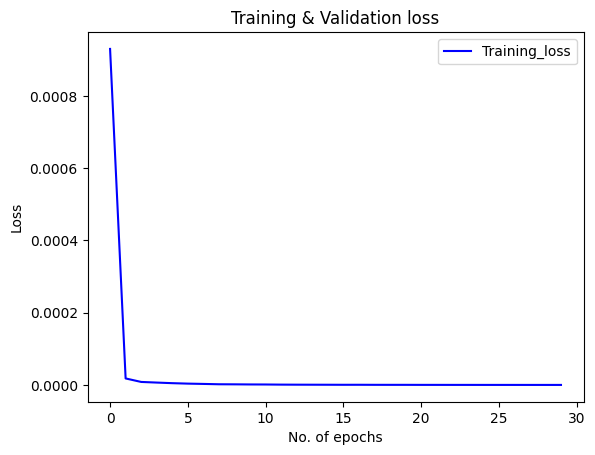

In [120]:
print("Best Loss:{:.8f}".format(best_loss))
plt_loss_accuracy_fig_2(total_train_loss)

In [126]:
vae = VAE().to(device)
pth_path = 'MNIST_TRAIN_VAE_linear_onlyKLD.pth'
state_dict = torch.load(pth_path)
vae.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
vae.eval()
eval_loss = nn.MSELoss()

Load pth from MNIST_TRAIN_VAE_linear_onlyKLD.pth


See the result of recreating.

Loss: [-4.43833414465189e-09, 2.5771441869437695e-08, -1.977605279535055e-08, 1.363514456897974e-08, 5.0771632231771946e-08]


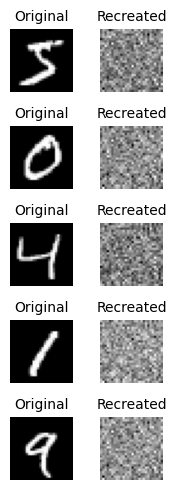

In [122]:
total_output = list()
total_test_loss = list()
for i in range(5):
    img, _ = mnist_train[i]
    img_batch = img.unsqueeze(0)
    output, loss = recreate_img_kld(img_batch, vae, eval_loss)
    total_output.append((img.cpu().detach().numpy().squeeze(0), output.cpu().detach().numpy().squeeze(0)))
    total_test_loss.append(loss.cpu().item())
print("Loss:", total_test_loss)

plt.figure(figsize=(2, 5))
for i, img_idx in enumerate(range(5)):
    img, output_img = total_output[img_idx]

    # image subplot
    ax_img = plt.subplot(5, 2, 2 * i + 1)
    ax_img.imshow(img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Original", fontsize=10)
    ax_img = plt.subplot(5, 2, 2 * i + 2)
    ax_img.imshow(output_img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Recreated", fontsize=10)
plt.tight_layout()
plt.show()


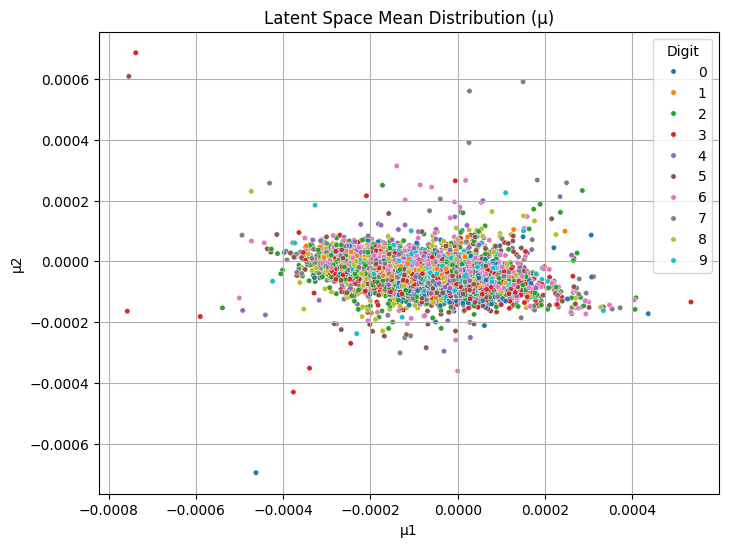

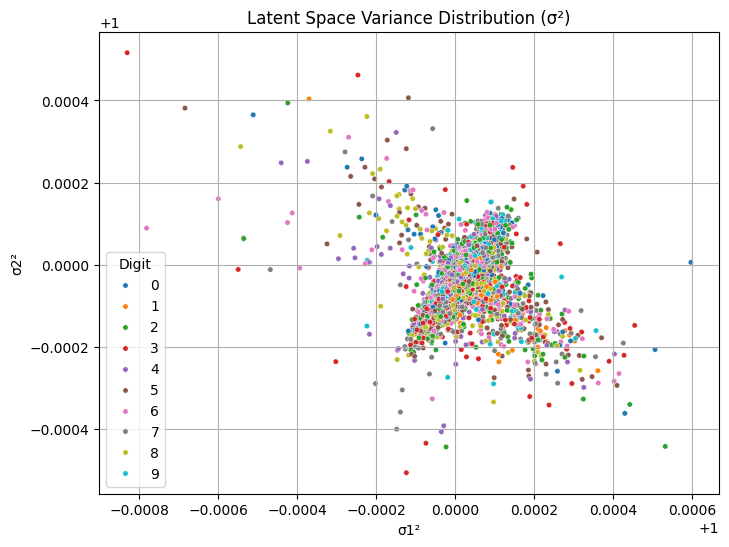

In [123]:
visualize_latent_stats(vae, train_loader, device)

Use decoder to generate some images.

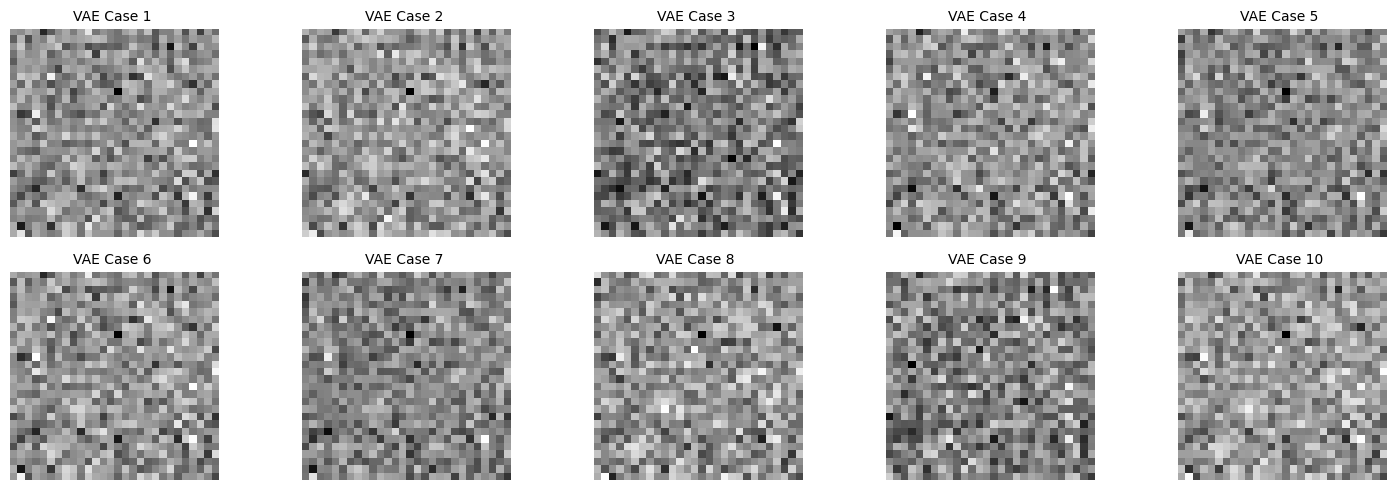

In [127]:
N = 10 # test cases number
# get the decoders
decoder_VAE = vae.decode
# input shape
input_vae = torch.zeros((1, 2))
plt.figure(figsize=(15, 5))
for i in range(N):
    with torch.no_grad():
        x = torch.randn_like(input_vae)
        x = x.to(device)
        out = decoder_VAE(x)
        ax = plt.subplot(2, 5, i+1)
        ax.imshow(out.cpu().squeeze(0,1), cmap='gray')
        ax.axis("off")
        ax.set_title(f"VAE Case {i+1} ", fontsize=10)
plt.tight_layout()
plt.show()

#### (c) Using both losses together

In [65]:
# Start training and testing
best_loss = 100
NUM_EPOCHS = 30
# For ploting the trend image
total_train_loss = []
for i in range(NUM_EPOCHS):
    train_loss = train_epoch_3(train_loader, vae, criterion, optimizer)
    # record the training data
    total_train_loss.append(train_loss)
    print("Epoch[{:>2d}/{:>2d}] : train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_loss))
    # update model pth when larger val_acc happens
    if(train_loss < best_loss):
        best_loss = train_loss
        save_parameters = True
        if save_parameters:
            path = 'MNIST_TRAIN_VAE_linear.pth'
            torch.save(vae.state_dict(), path)
            print("\t\33[33m==== Save model at epoch {:d} | best_loss = {:.4f} ====\33[0m".format(i+1, best_loss))

# save the final epoch's model
path = 'MNIST_TRAIN_VAE_linear_final_epoch.pth'
torch.save(vae.state_dict(), path)
print("\t\33[33m==== Save FINAL model parameters in {:s} ====\33[0m".format(path))

100%|██████████| 469/469 [00:24<00:00, 19.50it/s]


Epoch[ 1/30] : train_loss = 0.2795
	==== Save model at epoch 1 | best_loss = 0.2795 ====


100%|██████████| 469/469 [00:12<00:00, 36.23it/s]


Epoch[ 2/30] : train_loss = 0.2698
	==== Save model at epoch 2 | best_loss = 0.2698 ====


100%|██████████| 469/469 [00:12<00:00, 36.90it/s]


Epoch[ 3/30] : train_loss = 0.2696
	==== Save model at epoch 3 | best_loss = 0.2696 ====


100%|██████████| 469/469 [00:12<00:00, 36.83it/s]


Epoch[ 4/30] : train_loss = 0.2695
	==== Save model at epoch 4 | best_loss = 0.2695 ====


100%|██████████| 469/469 [00:15<00:00, 31.23it/s]


Epoch[ 5/30] : train_loss = 0.2694
	==== Save model at epoch 5 | best_loss = 0.2694 ====


100%|██████████| 469/469 [00:12<00:00, 36.43it/s]


Epoch[ 6/30] : train_loss = 0.2694
	==== Save model at epoch 6 | best_loss = 0.2694 ====


100%|██████████| 469/469 [00:12<00:00, 37.19it/s]


Epoch[ 7/30] : train_loss = 0.2693
	==== Save model at epoch 7 | best_loss = 0.2693 ====


100%|██████████| 469/469 [00:12<00:00, 36.60it/s]


Epoch[ 8/30] : train_loss = 0.2693
	==== Save model at epoch 8 | best_loss = 0.2693 ====


100%|██████████| 469/469 [00:13<00:00, 34.77it/s]


Epoch[ 9/30] : train_loss = 0.2692
	==== Save model at epoch 9 | best_loss = 0.2692 ====


100%|██████████| 469/469 [00:12<00:00, 36.59it/s]


Epoch[10/30] : train_loss = 0.2692
	==== Save model at epoch 10 | best_loss = 0.2692 ====


100%|██████████| 469/469 [00:13<00:00, 35.81it/s]


Epoch[11/30] : train_loss = 0.2692
	==== Save model at epoch 11 | best_loss = 0.2692 ====


100%|██████████| 469/469 [00:13<00:00, 35.71it/s]


Epoch[12/30] : train_loss = 0.2692
	==== Save model at epoch 12 | best_loss = 0.2692 ====


100%|██████████| 469/469 [00:12<00:00, 36.51it/s]


Epoch[13/30] : train_loss = 0.2691
	==== Save model at epoch 13 | best_loss = 0.2691 ====


100%|██████████| 469/469 [00:12<00:00, 36.48it/s]


Epoch[14/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:12<00:00, 36.34it/s]


Epoch[15/30] : train_loss = 0.2691
	==== Save model at epoch 15 | best_loss = 0.2691 ====


100%|██████████| 469/469 [00:13<00:00, 35.95it/s]


Epoch[16/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:12<00:00, 36.89it/s]


Epoch[17/30] : train_loss = 0.2691
	==== Save model at epoch 17 | best_loss = 0.2691 ====


100%|██████████| 469/469 [00:12<00:00, 36.78it/s]


Epoch[18/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:12<00:00, 37.02it/s]


Epoch[19/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:12<00:00, 36.49it/s]


Epoch[20/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:12<00:00, 36.73it/s]


Epoch[21/30] : train_loss = 0.2691
	==== Save model at epoch 21 | best_loss = 0.2691 ====


100%|██████████| 469/469 [00:12<00:00, 36.56it/s]


Epoch[22/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:12<00:00, 36.75it/s]


Epoch[23/30] : train_loss = 0.2691
	==== Save model at epoch 23 | best_loss = 0.2691 ====


100%|██████████| 469/469 [00:12<00:00, 37.29it/s]


Epoch[24/30] : train_loss = 0.2691
	==== Save model at epoch 24 | best_loss = 0.2691 ====


100%|██████████| 469/469 [00:12<00:00, 36.73it/s]


Epoch[25/30] : train_loss = 0.2691
	==== Save model at epoch 25 | best_loss = 0.2691 ====


100%|██████████| 469/469 [00:12<00:00, 36.86it/s]


Epoch[26/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:13<00:00, 35.88it/s]


Epoch[27/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:13<00:00, 35.16it/s]


Epoch[28/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:12<00:00, 36.16it/s]


Epoch[29/30] : train_loss = 0.2691


100%|██████████| 469/469 [00:13<00:00, 36.06it/s]

Epoch[30/30] : train_loss = 0.2691
	==== Save FINAL model parameters in MNIST_TRAIN_VAE_linear_final_epoch.pth ====


Best Loss: 0.26907651110498637


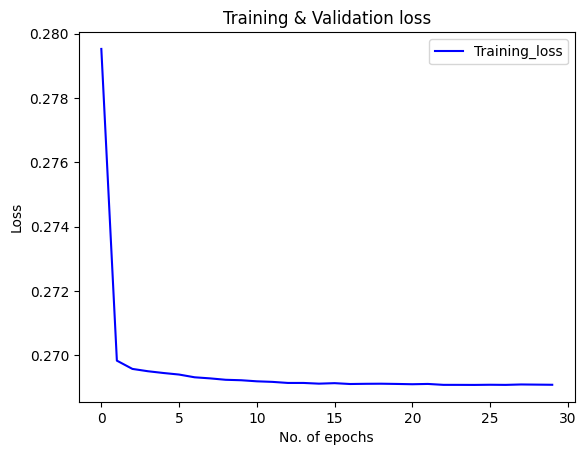

In [66]:
print("Best Loss:",best_loss)
plt_loss_accuracy_fig_2(total_train_loss)

In [124]:
vae = VAE().to(device)
pth_path = 'MNIST_TRAIN_VAE_linear.pth'
state_dict = torch.load(pth_path)
vae.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
vae.eval()
eval_loss = nn.MSELoss()

Load pth from MNIST_TRAIN_VAE_linear.pth


See the result of recreating.

Loss: [0.25432315468788147, 0.3039042353630066, 0.29552412033081055, 0.22317193448543549, 0.21132253110408783]


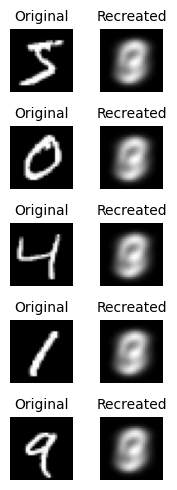

In [68]:
total_output = list()
total_test_loss = list()
for i in range(5):
    img, _ = mnist_train[i]
    img_batch = img.unsqueeze(0)
    output, loss = recreate_img_vae(img_batch, vae, eval_loss)
    total_output.append((img.cpu().detach().numpy().squeeze(0), output.cpu().detach().numpy().squeeze(0)))
    total_test_loss.append(loss.cpu().item())
print("Loss:", total_test_loss)

plt.figure(figsize=(2, 5))
for i, img_idx in enumerate(range(5)):
    img, output_img = total_output[img_idx]

    # image subplot
    ax_img = plt.subplot(5, 2, 2 * i + 1)
    ax_img.imshow(img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Original", fontsize=10)
    ax_img = plt.subplot(5, 2, 2 * i + 2)
    ax_img.imshow(output_img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Recreated", fontsize=10)
plt.tight_layout()
plt.show()


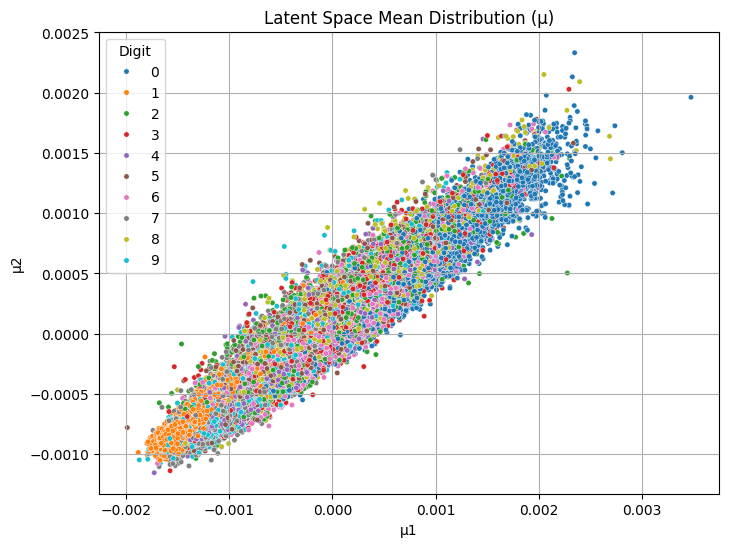

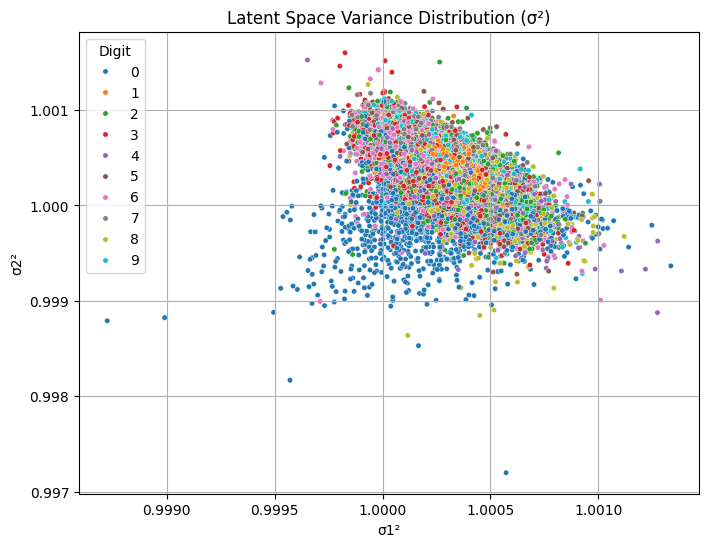

In [72]:
visualize_latent_stats(vae, train_loader, device)

Use decoder to generate some images.

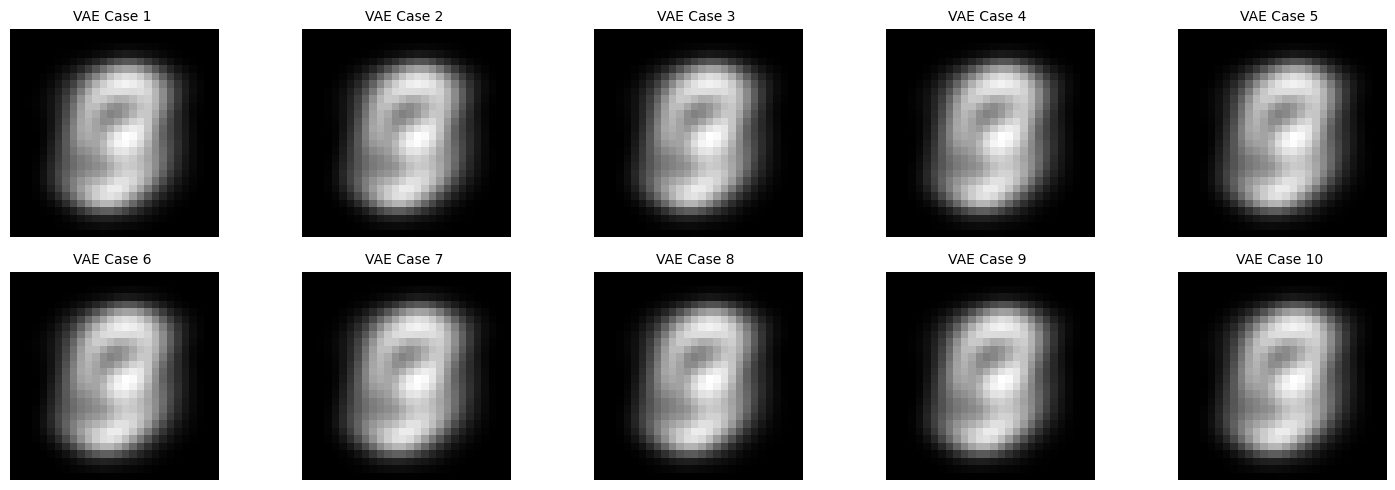

In [125]:
N = 10 # test cases number
# get the decoders
decoder_VAE = vae.decode
# input shape
input_vae = torch.zeros((1, 2))
plt.figure(figsize=(15, 5))
for i in range(N):
    with torch.no_grad():
        x = torch.randn_like(input_vae)
        x = x.to(device)
        out = decoder_VAE(x)
        ax = plt.subplot(2, 5, i+1)
        ax.imshow(out.cpu().squeeze(0,1), cmap='gray')
        ax.axis("off")
        ax.set_title(f"VAE Case {i+1} ", fontsize=10)
plt.tight_layout()
plt.show()

### ii.
The KL divergence loss measures how much the latent distribution
deviates from a standard normal distribution.    Discuss the potential
impact on the model behavior and latent space if the prior distribution
is changed from a normal distribution to a uniform distribution.


#### Discussion:
如果將latent space的分布從常態分佈改成均勻分布，會改變latent space的分布狀態，原先常態分佈是希望產生較接近0的數值，並對較外圍的空間有平滑過渡。而均勻分布在固定範圍內密度是常數、範圍外為 0，模型(encoder)可能會被迫把潛在表示限制在這個固定範圍內，均勻分佈會讓潛在空間的表達能力或聚類能力降低。  
由於latent space的分群效果變差，因此VAE中的decoder可能就較無法生成較正確的數字圖片。